# One Class SVM

The purpose of this notebook is to explore a one class SVM and its classification on American vs British audio. As of now our classification models primarily classify the british data as 'West'. I believe this may be in part to 'West' being the most distinct from the other accents and perhaps the model is simply classifying it as that because of how 'different' it is to the other accents rather than how 'similar' it is to the 'West'.


If we train a 1-class SVM against the entire American MFCC dataset, we can make predictions against our British dataset.


If the vast majority of British data gets classified as an outlier (outside the decision boundary) we can confidently say the British dataset is very distinct in its features. This would unfortunately remove even more validity from our classifier but it would provide insights as to why each classifier (Random Forest, Logistic Regression, XGBoost) always seem to classify as 'West'.

# Results:

- Model has a 98% test rate against American data *all is classified as American accents
- When the British model is supplied, 14% of the dataset it classified as an outlier

In [24]:
import pandas as pd
import os
from os.path import abspath, exists
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from sklearn.svm import SVC, OneClassSVM

from sklearn import metrics


sns.set()

In [27]:
train = pd.read_csv('all_words_train_mfcc.csv')

train.head()


,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,accent,gender,word,speaker
0,DR5,-439.344940,67.907349,-14.114124,17.912643,-26.638611,-31.654188,-20.502222,-23.842127,-23.093876,-16.234423,-8.496225,-5.522748,DR5,f,abbreviate,FLMK0
1,DR3,-408.231201,105.028801,-20.928425,25.700222,-3.437836,-30.381397,-5.896172,-16.891687,-4.583311,-26.853298,-10.679854,1.973731,DR3,m,abbreviate,MDLC0
2,DR7,-385.379791,91.537735,-45.475266,49.451881,-9.125413,-25.311602,-9.907626,-26.893835,-1.834932,-27.696819,-7.892810,-7.839106,DR7,m,abbreviate,MHBS0
3,DR4,-405.189941,91.437141,-40.871204,43.260582,-25.054419,-11.245912,-23.785265,-25.545288,-3.327228,-25.219856,-5.730671,-6.839403,DR4,m,abbreviate,MJRH0
4,DR2,-415.859924,70.842407,-36.314655,35.240990,-8.941346,-31.030230,-23.500427,-19.068901,-15.531343,-23.892067,-19.192522,-2.195710,DR2,m,abbreviate,MJRP0


In [41]:
def prep_train():
    feature_cols = ['feature_' + str(i) for i in range(1, 13)]
    feature_cols.append('foreign')
    
    df = pd.read_csv('accent-mfcc-data-1.csv')
    
    df['foreign'] = (df['language'] != 'US').astype('int')
    
    # drop british
    df_no_brits = df.loc[df['language'] != 'UK']
    
    del df_no_brits['language']
    
    df_no_brits.columns = feature_cols
    
    
    return df_no_brits


In [42]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data(remove_army = False):
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    if remove_army:
        train = train.loc[train['accent'] != 'DR8']
        test = test.loc[test['accent'] != 'DR8']

    test = test.loc[test.word.isin(train.word)].reset_index()
    
    
    train = average_speakers(train)
    
    feature_cols = [x for x in train.columns if 'feature' in x]

    train = train[feature_cols]
    test = test[feature_cols]
    
    train['foreign'] = 0
    test['foreign'] = 0
    
    add_data = prep_train()
    
    all_train = pd.concat([train, test, add_data])
        
    british_df = pd.read_csv('british_mfcc.csv')
    
    british_df['foreign'] = 1
    
    
    return all_train, british_df[feature_cols]


all_train, british_df = load_data()

In [43]:
all_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,foreign
0,-353.348083,134.518519,-9.184594,-18.755492,-21.228213,-6.953157,-22.371318,-27.997338,-5.364247,4.490220,-6.668658,0.257785,0
1,-347.818909,106.672279,-45.025673,18.032808,-14.631424,-27.376530,-19.641098,-15.697500,1.943836,-9.809213,4.143702,-5.511507,0
2,-360.966278,126.600243,-24.294479,-38.255478,-69.742477,-17.396694,20.758194,-35.852512,-4.462066,-16.974424,-4.133724,-1.038600,0
3,-317.568298,108.726196,-11.648054,-37.803394,-61.665752,-5.345030,0.926592,-29.949045,-6.787814,-16.826244,4.379314,-9.666162,0
4,-392.887268,107.063339,-18.115166,39.589870,-27.925322,-45.015396,-20.218822,-21.476480,0.229233,-33.994270,3.304021,-11.966344,0


In [46]:
def fit_one_c_svm(train, test, nu=0.01 ,max_score = False):
    feature_cols = [x for x in train.columns if 'feature' in x]
    
    features = train[feature_cols]
    target = train['foreign']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=33)
    american_train_X = X_train.take(np.where(y_train == 0)[0].tolist())

    if max_score:
        fig, ax = plt.subplots(figsize=(20,10))
       
        nu_score = []
        for i in np.arange(.01, 1, .01):
            clf = OneClassSVM(kernel='rbf', nu=i).fit(american_train_X)
            y_pred = clf.predict(X_test)

            y_pred[np.where(y_pred == 1)] = 0
            y_pred[np.where(y_pred == -1)] = 1

            acc = np.mean(y_pred == y_test)
            nu_score.append(acc)

        sns.lineplot(x=np.arange(.01, 1, .01), y = nu_score)
        
        return nu_score
        
    
    clf = OneClassSVM(kernel='rbf', nu = nu).fit(american_train_X)
    
    # -1 for outliers (SPAM aka label == 1), 1 for inliers aka NONSPAM (label == 0)
    y_pred = clf.predict(X_test)
    
    y_pred[np.where(y_pred == 1)] = 0
    y_pred[np.where(y_pred == -1)] = 1
    
    acc = np.mean(y_pred == y_test)
                
    return acc, clf, y_pred



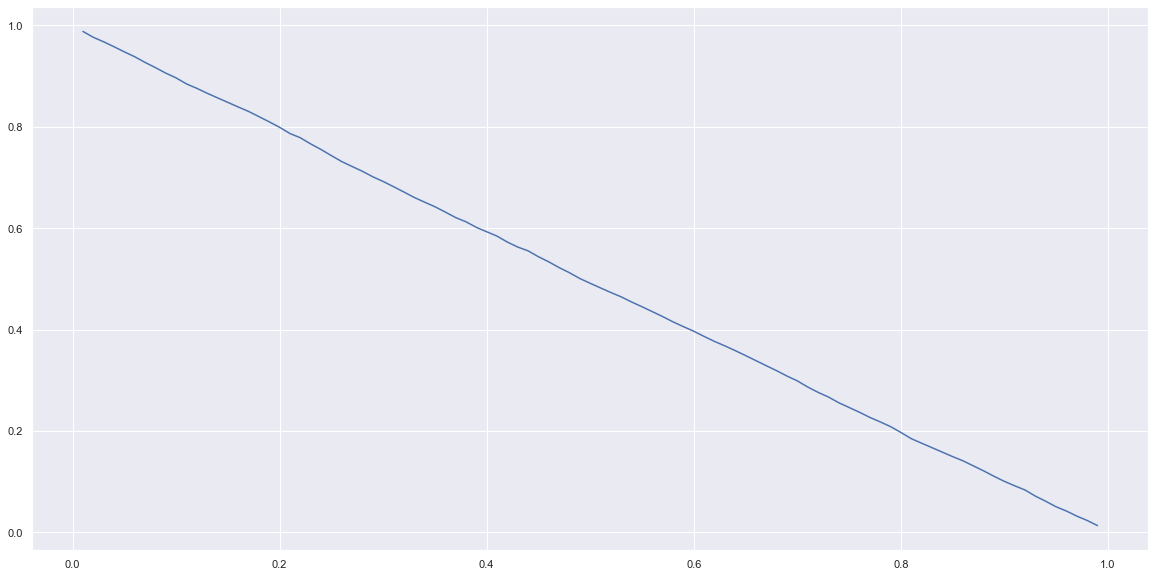

In [48]:
nu_score = fit_one_c_svm(all_train, british_df, max_score = True)

In [49]:
acc, clf, y_pred = fit_one_c_svm(all_train, test, nu=0.01)

In [50]:
acc

0.9896489168711984

In [51]:
def test_british_svm(british, clf):
    feature_cols = [x for x in british.columns if 'feature' in x]
    
    X_test = british[feature_cols]
    y_test = np.ones(len(british))
    
    y_pred = clf.predict(X_test)
    
    y_pred[np.where(y_pred == 1)] = 0
    y_pred[np.where(y_pred == -1)] = 1
    
    score = np.mean(y_test == y_pred)
    
    return score

    

In [52]:
score = test_british_svm(british_df, clf)

In [53]:
score

0.13114754098360656